In [5]:
import pandas as pd
import numpy as np
import wrds
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import time
import sklearn.linear_model,sklearn.decomposition
from datetime import datetime
import scipy.stats as stats

## Level data

In [7]:
# comp_level = data[data['cusip'].isin(stock_return_data.columns)].groupby(['cusip','date'])['prc'].first().unstack().T.loc['2015',:]
# comp_level.to_csv('D:\\data\\comp_level.csv')
comp_level = pd.read_csv('comp_level.csv')
comp_level.date = pd.to_datetime(comp_level.date)
sp500_level = pd.read_csv('sp500_level_2015.csv')[['Date','Adj Close']].rename({'Date':'date','Adj Close':'prc'},axis=1)
sp500_level.date = pd.to_datetime(sp500_level.date)

comp_level = comp_level.set_index('date').unstack().reset_index().rename({'level_0':'cusip',0:'comp_prc'},axis=1)
sp500_level['cusip'] = 1

## Index option data

In [8]:
index_option_data = pd.read_csv('index_option_data.csv')
index_option_data.date = pd.to_datetime(index_option_data.date)
index_option_data.exdate = pd.to_datetime(index_option_data.exdate)
index_option_data.date[0]

Timestamp('2015-01-02 00:00:00')

## Component option data

In [9]:
comp_option_data = pd.read_csv('selected_options_2015.csv')
comp_option_data.date = pd.to_datetime(comp_option_data.date)
comp_option_data.exdate = pd.to_datetime(comp_option_data.exdate)
comp_option_data.cusip = comp_option_data.cusip.astype(str)
comp_option_data['cusip'].replace({'5301510':'05301510'},inplace=True)
comp_option_data.sort_values(['date','exdate'],inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Stock return data

In [10]:
stock_return_data = pd.read_csv('selected_stock_return.csv')

## Signal data

In [11]:
signal_data = pd.read_csv('signal.csv')
signal_data.date = pd.to_datetime(signal_data.date)

## Selected stocks

In [12]:
final_stocks_data = pd.read_csv('final_stocks_data.csv',index_col=0)
final_stocks_data

,permno,p_value,cusip,comnam,ticker,q_cap
0,10145.0,1.026056e-07,43851610,HONEYWELL INTERNATIONAL INC,HON,5
1,89258.0,2.427128e-12,74432010,PRUDENTIAL FINANCIAL INC,PRU,5
2,49680.0,6.795357e-11,23585110,DANAHER CORP,DHR,5
3,17830.0,3.715220e-06,91301710,UNITED TECHNOLOGIES CORP,UTX,5
4,22592.0,1.383028e-08,88579Y10,3M CO,MMM,5
5,11703.0,5.490817e-10,26353410,DU PONT E I DE NEMOURS & CO,DD,5
6,44644.0,2.683844e-54,05301510,AUTOMATIC DATA PROCESSING INC,ADP,5
7,22103.0,1.783971e-03,29101110,EMERSON ELECTRIC CO,EMR,5
8,18542.0,2.791526e-06,14912310,CATERPILLAR INC,CAT,5
9,38703.0,1.050705e-24,94974610,WELLS FARGO & CO NEW,WFC,5


## Portfolio

In [8]:
A = comp_option_data[comp_option_data.cusip == final_stocks_data.cusip[0]].exdate.unique()
A.sort()
expiry_dates = A[:13]

In [9]:
index_option_data = index_option_data[index_option_data.exdate.isin(expiry_dates)]
comp_option_data = comp_option_data[comp_option_data.exdate.isin(expiry_dates)]

In [10]:
opt_data = pd.concat([index_option_data,comp_option_data])[['date','exdate','strike_price','best_bid','best_offer','cp_flag','cusip',\
                                                 'impl_volatility','delta','vega','open_interest','volume']]
opt_data.cusip = opt_data.cusip.fillna(1)
opt_data = opt_data[opt_data['cp_flag']=='C']

/Users/alun/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [11]:
signal_data['z'] = (signal_data['impl_corr']-signal_data['impl_corr'].rolling(30).mean())/signal_data['impl_corr'].rolling(30).std()

In [12]:
opt_data = pd.merge(opt_data,signal_data[['date','z']],on=['date'])

In [13]:
opt_data.sort_values(['date','cusip','exdate'])

,date,exdate,strike_price,best_bid,best_offer,cp_flag,cusip,impl_volatility,delta,vega,open_interest,volume,z
0,2015-01-02,2015-01-17,100000,1956.4,1959.60,C,1,NaN,NaN,NaN,5356,0,NaN
1,2015-01-02,2015-01-17,1000000,1056.7,1059.90,C,1,1.598820,0.993924,6.129469,41884,1500,NaN
2,2015-01-02,2015-01-17,1025000,1031.7,1034.90,C,1,1.548029,0.993750,6.300900,0,0,NaN
3,2015-01-02,2015-01-17,1050000,1006.7,1009.80,C,1,1.490604,0.993763,6.288437,52,0,NaN
4,2015-01-02,2015-01-17,1075000,981.7,984.80,C,1,1.442365,0.993582,6.466263,4,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
547365,2015-12-31,2016-01-15,65000,0.0,0.01,C,94974610,0.332542,0.004443,0.144028,9736,0,-1.02332
547366,2015-12-31,2016-01-15,67500,0.0,0.04,C,94974610,0.461571,0.011724,0.338087,46,0,-1.02332
547367,2015-12-31,2016-01-15,70000,0.0,0.04,C,94974610,0.527495,0.010431,0.304598,4019,0,-1.02332
547368,2015-12-31,2016-01-15,75000,0.0,0.03,C,94974610,0.628264,0.006889,0.212226,529,0,-1.02332


In [14]:
opt_data = \
pd.merge(
    pd.merge(opt_data,sp500_level,on=['date','cusip'],how='left'),
    comp_level,on=['date','cusip'],how='left')

In [15]:
opt_data.loc[:,'diff'] = np.where(opt_data['cusip']==1,abs(opt_data.loc[:,'strike_price']/1000 - opt_data.loc[:,'prc']),
                                    abs(opt_data.loc[:,'strike_price']/1000 - opt_data.loc[:,'comp_prc']))
ATM_data = opt_data.groupby(['cusip','date','exdate'])['diff'].min().reset_index()
ATM_data['ATM'] = 1
opt_data = pd.merge(opt_data,ATM_data,on=['cusip','date','exdate','diff'],how='left')

In [16]:
exdate_data = [np.nan]*len(opt_data.exdate.unique())
for i in range(len(opt_data.exdate.unique())):
    exdate_data[i] = opt_data[opt_data.exdate == opt_data.exdate.unique()[i]]

In [17]:
opt_data.exdate.unique()

array(['2015-01-17T00:00:00.000000000', '2015-02-20T00:00:00.000000000',
       '2015-03-20T00:00:00.000000000', '2015-04-17T00:00:00.000000000',
       '2015-06-19T00:00:00.000000000', '2015-09-18T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2015-05-15T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-08-21T00:00:00.000000000',
       '2015-10-16T00:00:00.000000000', '2015-12-18T00:00:00.000000000',
       '2015-11-20T00:00:00.000000000'], dtype='datetime64[ns]')

## pf code

In [18]:
pos = 0
z = signal_data['z'].tolist()
pf = [0]*len(z)

for i in range(len(z)-1):
    if (pos == 0) & (z[i]>1.5):
        pos = 1
        pf[i] = 1
    elif (pos == 1) & (z[i]>0.5):
        pos = 1
        pf[i] = 1
    else:
        pos = 0
        pf[i] = 0
        
signal_data['trade'] = pf

In [19]:
signal_data['enter'] = signal_data['trade'].diff()

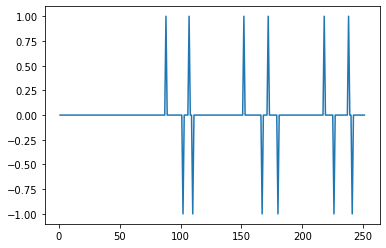

In [20]:
plt.plot(signal_data['enter'])

In [21]:
pf_data = pd.merge(exdate_data[1],signal_data[['date','z','trade','enter']],on=['date','z'],how='left')
pf_data[pf_data["enter"]==1]

,date,exdate,strike_price,best_bid,best_offer,cp_flag,cusip,impl_volatility,delta,vega,open_interest,volume,z,prc,comp_prc,diff,ATM,trade,enter


In [22]:
ATM_pf_data = pf_data[pf_data['ATM']==1]
ATM_pf_data

,date,exdate,strike_price,best_bid,best_offer,cp_flag,cusip,impl_volatility,delta,vega,open_interest,volume,z,prc,comp_prc,diff,ATM,trade,enter
163,2015-01-02,2015-02-20,2060000,38.60,41.10,C,1,0.142942,0.488878,297.05370,1252,60,NaN,2058.199951,NaN,1.800049,1.0,0,NaN
219,2015-01-02,2015-02-20,82500,2.45,2.70,C,05301510,0.176959,0.572911,11.97006,129,1,NaN,NaN,83.290001,0.790001,1.0,0,NaN
238,2015-01-02,2015-02-20,82500,12.90,15.80,C,05301510,NaN,NaN,NaN,24,0,NaN,NaN,83.290001,0.790001,1.0,0,NaN
266,2015-01-02,2015-02-20,92500,2.55,2.62,C,14912310,0.237018,0.454799,13.17936,1496,185,NaN,NaN,91.879997,0.620003,1.0,0,NaN
278,2015-01-02,2015-02-20,85000,2.80,3.00,C,23585110,0.201253,0.561640,12.38006,75,3,NaN,NaN,85.720001,0.720001,1.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19165,2015-02-20,2015-02-20,105000,0.27,0.38,C,43851610,NaN,NaN,NaN,1621,1194,-0.078309,NaN,105.360001,0.360001,1.0,0,0.0
19204,2015-02-20,2015-02-20,167500,0.41,0.52,C,88579Y10,NaN,NaN,NaN,1021,720,-0.078309,NaN,168.119995,0.619995,1.0,0,0.0
19255,2015-02-20,2015-02-20,124000,0.03,0.15,C,91301710,NaN,NaN,NaN,6,4526,-0.078309,NaN,124.110001,0.110001,1.0,0,0.0
19316,2015-02-20,2015-02-20,55000,0.01,0.02,C,94974610,NaN,NaN,NaN,14490,1403,-0.078309,NaN,54.830002,0.169998,1.0,0,0.0


In [23]:
pc=pd.pivot_table(ATM_pf_data, index=['date'], columns=['cusip'], values=['best_offer'])
pc

best_offer                                                        \
cusip               1 05301510 14912310 23585110 26054310 26353410 29101110   
date                                                                          
2015-01-02       41.1   9.2500     2.62     3.00     1.72     2.72     1.55   
2015-01-05       46.1   9.4000     2.93     2.55     2.06     1.65     2.35   
2015-01-06       45.3   8.7750     2.71     2.25     2.28     2.60     2.30   
2015-01-07       43.4   9.4250     3.15     2.35     2.14     1.94     2.05   
2015-01-08       39.9   9.0500     3.45     3.00     2.10     1.87     1.45   
2015-01-09       40.1   8.5750     2.82     2.65     2.01     2.61     2.35   
2015-01-12       40.6   7.9000     2.43     2.20     1.85     1.73     1.90   
2015-01-13       40.4   8.2500     2.07     1.95     1.53     2.34     1.80   
2015-01-14       44.0   9.9500     3.30     2.70     2.06     2.29     1.55   
2015-01-15       44.4  10.1000     2.66     2.35     1.93     2.40     1.45   
2015-01-16       41.0   8.2250     2.34     2.25     1.57     1.57     1.85   
2015-01-20       36.6   8.6250     2.55     2.40     1.62     1.69     1.80   
2015-01-21       37.3   8.4000     2.31     2.50     1.58     1.81     2.10   
2015-01-22       28.7   8.3250     2.24     1.70     1.24     1.51     1.30   
2015-01-23       30.4   8.9000     2.42     1.55     1.33     1.33     1.75   
2015-01-26       27.1   8.2500     2.62     2.60     1.27     1.42     1.15   
2015-01-27       30.2   9.8500     1.85     1.35     1.37     1.37     1.45   
2015-01-28       35.7   9.3250     1.90     1.95     1.36     1.45     2.40   
2015-01-29       30.0   8.1500     1.73     1.05     1.18     1.31     1.35   
2015-01-30       34.2   8.6000     1.76     1.60     1.25     1.41     1.45   
2015-02-02       26.9   9.3000     1.55     2.20     1.19     1.23     1.10   
2015-02-03       22.9   8.6250     1.53     1.30     0.95     0.95     0.75   
2015-02-04       23.8   7.5000     1.48     1.00     1.09     1.07     0.90   
2015-02-05       20.5   8.3250     1.47     1.50     0.86     0.96     0.75   
2015-02-06       21.7   7.8750     1.40     1.10     0.83     0.87     0.60   
2015-02-09       21.7   9.5250     1.35     0.85     0.73     0.88     0.70   
2015-02-10       17.0   7.8750     1.15     1.25     0.76     0.69     0.90   
2015-02-11       15.0   7.8500     1.03     1.30     0.78     0.84     0.95   
2015-02-12       11.1   8.5500     0.93     0.40     0.68     0.57     1.50   
2015-02-13       11.8   8.4875     0.96     0.40     0.54     0.75     1.55   
2015-02-17        7.3   8.0250     0.62     0.25     0.40     0.44     1.05   
2015-02-18        5.6   8.3750     0.43     0.40     0.31     0.30     0.15   
2015-02-19        4.5   8.5000     0.30     0.20     0.35     0.33     1.45   
2015-02-20        NaN   9.3250     0.02     0.40     0.06     0.15     1.30   

                                                                  
cusip      36960410 43851610 74432010 88579Y10 91301710 94974610  
date                                                              
2015-01-02     0.72    2.860     3.20     3.50     3.35    1.170  
2015-01-05     0.51    3.400     3.35     4.30     2.36    1.870  
2015-01-06     0.75    3.600     3.60     3.55     4.25    1.250  
2015-01-07     0.71    2.140     3.55     4.00     2.09    1.350  
2015-01-08     0.86    2.870     2.60     3.10     2.77    1.900  
2015-01-09     0.67    2.260     3.25     4.90     2.37    1.470  
2015-01-12     0.62    3.150     2.53     4.30     2.64    1.070  
2015-01-13     0.54    2.050     3.50     4.10     2.43    0.920  
2015-01-14     0.52    3.400     3.65     3.75     2.02    1.365  
2015-01-15     0.45    2.520     2.76     3.80     2.12    1.710  
2015-01-16     0.41    2.980     3.35     4.95     3.30    0.670  
2015-01-20     0.44    1.710     2.84     3.05     2.05    0.980  
2015-01-21     0.55    1.850     2.69     3.30     2.30    1.010  
2015-01-22     

In [24]:
pd.pivot_table(ATM_pf_data, index=['date'], columns=['cusip'], values=['strike_price'])

strike_price                                                        \
cusip                 1 05301510 14912310 23585110 26054310 26353410 29101110   
date                                                                            
2015-01-02    2060000.0  82500.0  92500.0  85000.0  46000.0  72500.0  62500.0   
2015-01-05    2020000.0  82500.0  87500.0  85000.0  44000.0  72500.0  60000.0   
2015-01-06    2005000.0  82500.0  87500.0  85000.0  43000.0  70000.0  60000.0   
2015-01-07    2025000.0  82500.0  87500.0  85000.0  43000.0  72500.0  60000.0   
2015-01-08    2060000.0  85000.0  87500.0  85000.0  44000.0  75000.0  62500.0   
2015-01-09    2045000.0  85000.0  87500.0  85000.0  44000.0  72500.0  60000.0   
2015-01-12    2030000.0  85000.0  87500.0  85000.0  44000.0  75000.0  60000.0   
2015-01-13    2025000.0  85000.0  87500.0  85000.0  44000.0  72500.0  60000.0   
2015-01-14    2010000.0  82500.0  85000.0  82500.0  43000.0  72500.0  60000.0   
2015-01-15    1995000.0  82500.0  85000.0  82500.0  43000.0  72500.0  60000.0   
2015-01-16    2020000.0  85000.0  85000.0  82500.0  45000.0  75000.0  60000.0   
2015-01-20    2025000.0  85000.0  84000.0  82500.0  44000.0  74500.0  60000.0   
2015-01-21    2030000.0  85000.0  85500.0  82500.0  44500.0  74000.0  60000.0   
2015-01-22    2065000.0  87500.0  87000.0  85000.0  45500.0  75000.0  60000.0   
2015-01-23    2050000.0  87500.0  85500.0  85000.0  44500.0  74000.0  57500.0   
2015-01-26    2055000.0  87500.0  86000.0  82500.0  44500.0  74000.0  60000.0   
2015-01-27    2030000.0  85000.0  80000.0  85000.0  44000.0  73000.0  57500.0   
2015-01-28    2000000.0  85000.0  80000.0  82500.0  43000.0  71500.0  55000.0   
2015-01-29    2020000.0  85000.0  80000.0  85000.0  45000.0  72500.0  57500.0   
2015-01-30    1995000.0  82500.0  80000.0  82500.0  45000.0  71000.0  57500.0   
2015-02-02    2020000.0  82500.0  81000.0  82500.0  45000.0  71500.0  60000.0   
2015-02-03    2050000.0  85000.0  84000.0  85000.0  47000.0  73500.0  60000.0   
2015-02-04    2040000.0  87500.0  82000.0  85000.0  46000.0  73500.0  57500.0   
2015-02-05    2065000.0  87500.0  83500.0  85000.0  48000.0  76000.0  57500.0   
2015-02-06    2055000.0  87500.0  83000.0  85000.0  48500.0  76000.0  57500.0   
2015-02-09    2045000.0  85000.0  84500.0  85000.0  48500.0  75500.0  57500.0   
2015-02-10    2070000.0  87500.0  84000.0  85000.0  48500.0  76000.0  57500.0   
2015-02-11    2070000.0  87500.0  83500.0  85000.0  48000.0  75250.0  57500.0   
2015-02-12    2090000.0  87500.0  83500.0  87500.0  49000.0  76500.0  57500.0   
2015-02-13    2095000.0  88750.0  85000.0  87500.0  49500.0  76000.0  57500.0   
2015-02-17    2100000.0  87500.0  85500.0  87500.0  49500.0  76500.0  57500.0   
2015-02-18    2100000.0  87500.0  85000.0  87500.0  49500.0  76500.0  60000.0   
2015-02-19    2095000.0  87500.0  83500.0  87500.0  49500.0  76000.0  57500.0   
2015-02-20          NaN  87500.0  84500.0  87500.0  49500.0  76500.0  57500.0   

                                                                     
cusip      36960410  43851610 74432010  88579Y10  91301710 94974610  
date                                                                 
2015-01-02  25000.0  100000.0  90000.0  165000.0  115000.0  55000.0  
2015-01-05  25000.0   97500.0  87500.0  160000.0  115000.0  52500.0  
2015-01-06  24000.0   97500.0  85000.0  160000.0  110000.0  52500.0  
2015-01-07  24000.0  100000.0  85000.0  160000.0  115000.0  52500.0  
2015-01-08  24000.0  100000.0  87500.0  165000.0  115000.0  52500.0  
2015-01-09  24000.0  100000.0  85000.0  160000.0  115000.0  52500.0  
2015-01-12  24000.0   97500.0  85000.0  160000.0  115000.0  52500.0  
2015-01-13  24000.0  100000.0  82500.0  160000.0  115000.0  52500.0  
2015-01-14  24000.0   97500.0  80000.0  160000.0  115000.0  51250.0  
2015-01-15  24000.0   97500.0  80000.0  160000.0  115000.0  50000.0  
2015-01-16  24000.0   97500.0  80000.0  160000.0  115000.0  52500.0  
2015-01-20  24000.0  100000.0  80

In [25]:
pd.pivot_table(ATM_pf_data, index=['date'], columns=['cusip'], values=['comp_prc'])

comp_prc                                                         \
cusip        05301510   14912310   23585110   26054310   26353410   29101110   
date                                                                           
2015-01-02  83.290001  91.879997  85.720001  45.590000  73.709999  61.790001   
2015-01-05  83.230003  87.029999  84.870003  44.180000  71.720001  60.520000   
2015-01-06  82.535004  86.470001  84.290001  43.470001  70.889999  60.419998   
2015-01-07  83.260002  87.809998  84.800003  43.400002  72.309998  60.290001   
2015-01-08  85.169998  88.709999  86.110001  44.480000  74.529999  61.869999   
2015-01-09  84.559998  87.650002  85.529999  44.410000  73.500000  60.900002   
2015-01-12  84.144997  86.889999  84.470001  44.150002  74.410004  60.169998   
2015-01-13  83.980003  86.370003  84.349998  43.610001  73.139999  60.080002   
2015-01-14  83.735001  86.070000  83.019997  43.430000  72.949997  59.619999   
2015-01-15  83.699997  84.320000  82.029999  43.310001  73.150002  59.380001   
2015-01-16  84.570000  83.860001  82.540001  44.790001  74.250000  60.349998   
2015-01-20  84.970001  83.970001  82.970001  44.130001  74.360001  60.480000   
2015-01-21  84.559998  85.370003  83.260002  44.740002  74.180000  60.980000   
2015-01-22  86.610001  86.820000  84.500000  45.360001  75.089996  59.810001   
2015-01-23  86.849998  85.610001  84.139999  44.570000  73.790001  58.119999   
2015-01-26  86.570000  86.029999  83.660004  44.560001  74.110001  59.430000   
2015-01-27  85.629997  79.849998  84.639999  44.169998  73.180000  57.299999   
2015-01-28  84.529999  80.010002  82.849998  43.029999  71.709999  56.230000   
2015-01-29  84.349998  80.000000  83.930000  45.009998  72.709999  56.880001   
2015-01-30  82.529999  79.970001  82.379997  45.160000  71.209999  56.939999   
2015-02-02  83.440002  80.839996  83.739998  45.220001  71.610001  58.970001   
2015-02-03  85.139999  83.919998  85.019997  46.889999  73.330002  59.439999   
2015-02-04  86.580002  81.949997  84.339996  46.220001  73.739998  57.330002   
2015-02-05  87.169998  83.570000  85.480003  47.799999  76.000000  57.150002   
2015-02-06  86.440002  83.209999  84.790001  48.400002  76.099998  57.029999   
2015-02-09  86.010002  84.669998  84.449997  48.259998  75.720001  57.349998   
2015-02-10  86.519997  83.900002  85.459999  48.500000  75.980003  58.040001   
2015-02-11  86.820000  83.410004  85.660004  48.080002  75.250000  57.689999   
2015-02-12  87.745003  83.529999  86.599998  49.150002  76.290001  58.599998   
2015-02-13  88.750000  85.129997  86.809998  49.439999  76.180000  58.680000   
2015-02-17  87.110001  85.379997  86.800003  49.570000  76.430000  58.299999   
2015-02-18  87.589996  84.800003  87.449997  49.410000  76.309998  58.849998   
2015-02-19  87.730003  83.300003  87.239998  49.680000  76.080002  58.689999   
2015-02-20  88.684998  84.440002  87.680000  49.529999  76.669998  58.669998   

                                                                      \
cusip        36960410    43851610   74432010    88579Y10    91301710   
date                                                                   
2015-01-02  25.059999  100.230003  90.110001  164.059998  115.040001   
2015-01-05  24.600000   98.320000  87.250000  160.360001  113.120003   
2015-01-06  24.070000   98.089996  85.440002  158.649994  111.519997   
2015-01-07  24.080000   98.800003  85.489998  159.800003  112.730003   
2015-01-08  24.370001  100.599998  86.860001  163.630005  114.650002   
2015-01-09  24.030001   98.930000  85.320000  161.619995  114.019997   
2015-01-12  23.980000   98.449997  84.209999  160.740005  114.449997   
2015-01-13  23.860001   99.150002  83.379997  160.619995  114.339996   
2015-01-14  23.780001   98.690002  81.180000  159.839996  113.519997   
2015-01-15  23.580000   97.110001  79.779999  159.660004  113.519997   
2015-01-16  23.590000   98.220001  81.000000  162.000000  116.150002   
2015-01-20  23.850000   98.980003  80.510002

In [26]:
signal_data

,date,05301510,14912310,23585110,26054310,26353410,29101110,36960410,43851610,74432010,88579Y10,91301710,94974610,est_iv,impl_corr,samp_corr,z,trade,enter
0,2015-01-02,0.241244,0.243253,0.249607,0.300398,0.199400,0.275448,0.190315,0.234863,0.309888,0.175709,0.195261,0.180282,0.139078,0.528520,NaN,NaN,0,NaN
1,2015-01-05,0.302726,0.289465,0.312167,0.329478,0.219224,0.413997,0.210319,0.336996,0.417939,0.196778,0.214078,0.216066,0.167306,0.494560,NaN,NaN,0,0.0
2,2015-01-06,0.329545,0.295397,0.329267,0.335397,0.232548,0.414684,0.223968,0.363222,0.470390,0.206103,0.218662,0.232931,0.176184,0.473847,NaN,NaN,0,0.0
3,2015-01-07,0.335007,0.288359,0.324644,0.331032,0.221129,0.404459,0.216986,0.311421,0.464329,0.200912,0.211735,0.219549,0.163937,0.417544,NaN,NaN,0,0.0
4,2015-01-08,0.275872,0.267229,0.322214,0.311664,0.233708,0.337579,0.197657,0.302203,0.405764,0.188105,0.200493,0.200064,0.143450,0.387816,NaN,NaN,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2015-12-24,0.203999,0.246217,0.224315,0.262437,0.262933,0.258714,0.169090,0.192182,0.265060,0.166781,0.150798,0.176413,0.137305,0.649510,0.526222,-0.894966,0,0.0
248,2015-12-28,0.228733,0.275463,0.251992,0.279844,0.270924,0.293395,0.176975,0.217292,0.309612,0.190483,0.167962,0.185065,0.146302,0.594238,0.524112,-1.199435,0,0.0
249,2015-12-29,0.218700,0.281005,0.213638,0.271163,0.272466,0.297030,0.170996,0.223814,0.310994,0.180925,0.167354,0.172848,0.135706,0.535013,0.542264,-1.491318,0,0.0
250,2015-12-30,0.215025,0.289292,0.250615,0.275647,0.267408,0.300359,0.180901,0.230497,0.306581,0.189859,0.176929,0.178490,0.143890,0.584412,0.540056,-1.083288,0,0.0


In [27]:
flag=0
money_account=100
wealth=[]
pnl=[]
gd=[]
for t in signal_data.date[1:215]:
    if int(signal_data.loc[signal_data["date"]==t]["enter"])==1 and flag!=1 and t!="2015-11-12":
        a=[]
        for ch in opt_data.exdate.unique():
            a.append(-(t-ch).days-30)
        pos=[x for x in a if x >=0]
        neg=[x for x in a if x <0]
        pos.sort()
        an=pos[0]
        x=a.index(an)
        exd=opt_data.exdate.unique()[x]
        pf_data = pd.merge(exdate_data[x],signal_data[['date','z','trade','enter']],on=['date','z'],how='left')
        ATM_pf_data = pf_data[pf_data['ATM']==1]
        pc=pd.pivot_table(ATM_pf_data, index=['date'], columns=['cusip'], values=['best_offer'])
        #opt_pr=pc.loc[t,:][0]
        wt_dic=dict({'43851610': -0.05571367850727131,
         '74432010': -0.07187119849038558,
         '23585110': -0.06304465843304669,
         '91301710': -0.05194112850234995,
         '88579Y10': -0.0619526010986947,
         '26353410': -0.05891725127453852,
         '05301510': -0.1812171670077421,
         '29101110': -0.02598803859897631,
         '14912310': -0.03419706124362839,
         '94974610': -0.07879385654612472,
         '26054310': -0.03445486694171087,
         '36960410': -0.07643511949743396,
                    1:1})
        cusip_list=[]
        for ch in pc.columns:
            cusip_list.append(ch[1])
        port_wt=[wt_dic[x] for x in cusip_list]
        print("long")
        print(t)
        print(exd)
        print(sum(pc.loc[t,:].multiply(port_wt)))
        earn=sum(pc.loc[t,:].multiply(port_wt))
        temp=earn
        #gd.append([t,earn])
        money_account+=sum(pc.loc[t,:].multiply(port_wt))
        wealth.append([t,money_account])
        st_pr=pd.pivot_table(ATM_pf_data, index=['date'], columns=['cusip'], values=['strike_price'])
        st_temp=st_pr.loc[t,:].to_list()
        #cusip=[x[1] for x in st_l.index.to_list()]
        temp_dict=dict(zip(cusip_list,st_temp))
        flag=1
        gd.append([t,0])
        #print(st_temp[0])
        print("------------------------")
        
        
        
    #if signal_data.loc[signal_data["date"]==t]["enter"].item==0 and :
    if int(signal_data.loc[signal_data["date"]==t]["enter"])==1 and flag==1:
        gd.append([t,0])
    if int(signal_data.loc[signal_data["date"]==t]["enter"])==0 and flag!=1:
        gd.append([t,0])
    
    if int(signal_data.loc[signal_data["date"]==t]["enter"])==-1:
        print(t)
        current_pr=[]
        for ch in cusip_list[1:]:
            criterion=(comp_option_data["date"]==t)&(comp_option_data["cusip"]==ch)&(comp_option_data["strike_price"]==temp_dict[ch])&(comp_option_data["exdate"]==exd)&(comp_option_data["cp_flag"]=="C")
            compop=comp_option_data.loc[criterion]["best_offer"].values[0]
            current_pr.append(compop)    
        indexop=index_option_data.loc[(index_option_data["date"]==t)&(index_option_data["cp_flag"]=="C")&(index_option_data["exdate"]==exd)&(index_option_data["strike_price"]==st_temp[0])]["best_bid"].values[0]
        current_pr.insert(0,indexop)
        #print(current_pr)
        port_wt_2=[-x for x in port_wt]
        cur=[x*y for x,y in zip(current_pr,port_wt_2)]
        print("short")
        print(sum(cur))
        temp+=sum(cur)
        pnl.append([t,temp])
        money_account+=sum(cur)
        wealth.append([t,money_account])
        temp=0
        
        flag=0
        temp_dict=[]
        exd=0
        gd.append([t,0])
        print("----------------------------------------------------------------")
    if int(signal_data.loc[signal_data["date"]==t]["enter"])==0 and flag==1:
        temp_pr=[]
        for ch in cusip_list[1:]:
            criterion=(comp_option_data["date"]==t)&(comp_option_data["cusip"]==ch)&(comp_option_data["strike_price"]==temp_dict[ch])&(comp_option_data["exdate"]==exd)&(comp_option_data["cp_flag"]=="C")
            compop=comp_option_data.loc[criterion]["best_offer"].values[0]
            temp_pr.append(compop)    
        indexop=index_option_data.loc[(index_option_data["date"]==t)&(index_option_data["cp_flag"]=="C")&(index_option_data["exdate"]==exd)&(index_option_data["strike_price"]==st_temp[0])]["best_bid"].values[0]
        temp_pr.insert(0,indexop)
        #print(current_pr)
        port_wt_2=[-x for x in port_wt]
        cur=[x*y for x,y in zip(temp_pr,port_wt_2)]
        pandl=temp+sum(cur)
        gd.append([t,pandl])
        pandl=0
        
        
money_account
        
            
        
        
        




#pc.index.astype(str)
#pc.loc[t,:]
# for ch in range(10,220):
#     t=signal_data.date[ch]
#     if signal_data.loc[signal_data["date"]==t]["enter"].item()==1:
#         print(ch)
#t.to_datetime()
#pc.index
#datetime.fromtimestamp(time.strftime("%s", t))
#time.strftime("%s", t)
#datetime.strptime(t,"%Y-%m-%d")

#pc.index=pd.to_datetime(pc.index)
#pc.index

#pc.index


#pc.index




long
2015-05-11 00:00:00
2015-06-19T00:00:00.000000000
31.82451976651154
------------------------
2015-06-01 00:00:00
short
-24.212374828026835
----------------------------------------------------------------
long
2015-06-08 00:00:00
2015-07-17T00:00:00.000000000
34.80392939001103
------------------------
2015-06-11 00:00:00
short
-44.70156316792354
----------------------------------------------------------------
long
2015-08-11 00:00:00
2015-09-18T00:00:00.000000000
31.26311362721412
------------------------
2015-09-01 00:00:00
short
-0.5894350533399167
----------------------------------------------------------------
long
2015-09-09 00:00:00
2015-10-16T00:00:00.000000000
51.70857565613363
------------------------
2015-09-21 00:00:00
short
-49.66910185174158
----------------------------------------------------------------


130.42766353883846

In [28]:
pd.Series(good).cumsum()

NameError: name 'good' is not defined

In [ ]:
ok=[x[0] for x in gd]
good=[x[1] for x in gd]
plt.figure(figsize=(20, 20), dpi=80)
plt.bar(ok,good)

In [ ]:
a

In [ ]:
timeline=[x[0] for x in pnl]
p=[x[1] for x in pnl]
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(timeline,p)
#pd.Series(p).cumsum()
a=[x/100 for x in p]
kur = stats.kurtosis(a, fisher=True)
np.std(a)
stats.skew(a)
((130.42766353883846-100)/100-0.0191)/(np.std(a)/np.sqrt(36)*np.sqrt(252))
# ((130.42766353883846-100)/100-0.0191)
# (stats.skew(a)*np.sqrt(25))
# stats.skew(a)
#stats.skew(a)
np.std(a)
(130.42766353883846-100)/100
np.sqrt(25)
((130.42766353883846-100)/100-0.0191)/(np.std(a)/np.sqrt(36)*np.sqrt(252))
#np.std(a)/np.sqrt(36)*np.sqrt(252)

In [ ]:
((130.42766353883846-100)/100-0.0191)/(stats.skew(a)*np.sqrt(252))
a

In [ ]:
stats.skew(a)

In [ ]:
p

In [ ]:
timeline=[x[0] for x in wealth]
p=[x[1] for x in wealth]
plt.figure(figsize=(20, 20), dpi=80)
plt.plot(timeline,p)

In [ ]:
p

In [ ]:
(142.41607432849574-97.7145111605722)/142.41607432849574

In [ ]:
(180.09676539058003-130.42766353883846)/180.09676539058003

In [ ]:
(money_account-100)/100

In [ ]:
t="2015-11-24"
exd="2015-12-18"
f=85000
index_option_data
index_option_data.loc[(index_option_data["date"]==t)]&(index_option_data["cp_flag"]=="C")]#&(index_option_data["exdate"]==exd)]#&(index_option_data["strike_price"]==f)]






signal_data.date

In [ ]:
a=signal_data.date.to_list()#.index("2015-11-12")#.["2015-11-12"]

In [ ]:
a.index('2015-11-12 00:00:00')